In [ ]:
!pip install --upgrade transformers --quiet


In [ ]:
import os
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"

import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
import random


In [ ]:
import pandas as pd


# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Combined Data.csv")

# Keep only required columns
df = df.dropna(subset=['statement', 'status'])

# Encode labels
label_map = {label: i for i, label in enumerate(df["status"].unique())}
df["label"] = df["status"].map(label_map)

print("✅ Label mapping:", label_map)
print("Sample data:\n", df.head())



✅ Label mapping: {'Anxiety': 0, 'Normal': 1, 'Depression': 2, 'Suicidal': 3, 'Stress': 4, 'Bipolar': 5, 'Personality disorder': 6}
Sample data:
    Unnamed: 0                                          statement   status  \
0           0                                         oh my gosh  Anxiety   
1           1  trouble sleeping, confused mind, restless hear...  Anxiety   
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3           3  I've shifted my focus to something else but I'...  Anxiety   
4           4  I'm restless and restless, it's been a month n...  Anxiety   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["statement"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [ ]:
def train_and_evaluate(hyperparams):
    # Load model with new classification head
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=len(label_map)
    )

    # Training arguments (compatible with older versions)
    training_args = TrainingArguments(
        output_dir="./results",
        learning_rate=hyperparams['learning_rate'],
        per_device_train_batch_size=hyperparams['train_batch_size'],
        per_device_eval_batch_size=hyperparams['eval_batch_size'],
        num_train_epochs=hyperparams['num_train_epochs'],
        weight_decay=hyperparams['weight_decay'],
        logging_dir='./logs',
        logging_steps=10,
        save_total_limit=1
        # Removed evaluation_strategy="epoch" for compatibility
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train
    trainer.train()

    # Evaluate after training
    eval_results = trainer.evaluate()

    # Collect logs for plotting
    logs = pd.DataFrame(trainer.state.log_history)
    train_loss = logs[logs['loss'].notnull()][['step', 'loss']]
    eval_loss = logs[logs['eval_loss'].notnull()][['step', 'eval_loss']]

    return trainer, eval_results, train_loss, eval_loss


Total sampled hyperparameter sets: 2

🔹 Running hyperparameter set 1/2: {'weight_decay': 0.0, 'train_batch_size': 8, 'num_train_epochs': 2, 'learning_rate': 3e-05, 'eval_batch_size': 8}


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3610022343.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,1.911200
20,1.663100
30,1.518700
40,1.361200
50,1.554300
60,1.087600
70,1.261400
80,1.140200
90,1.284600
100,1.289900


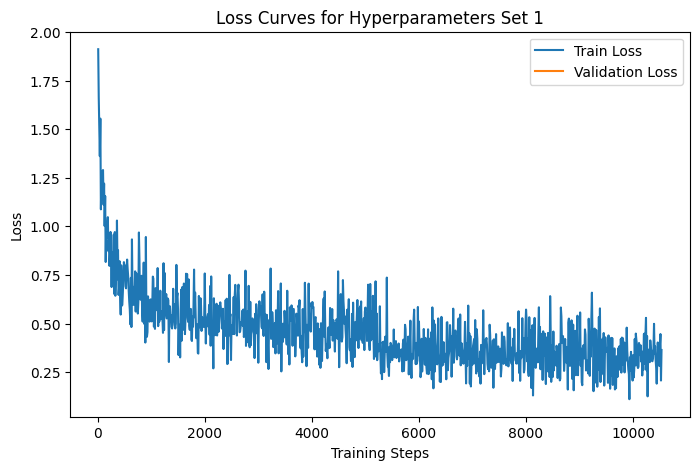


🔹 Running hyperparameter set 2/2: {'weight_decay': 0.0, 'train_batch_size': 8, 'num_train_epochs': 2, 'learning_rate': 5e-05, 'eval_batch_size': 8}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3610022343.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,1.870700
20,1.560100
30,1.295600
40,1.168500
50,1.330600
60,0.942700
70,1.097600
80,1.021300
90,1.089900
100,1.161700


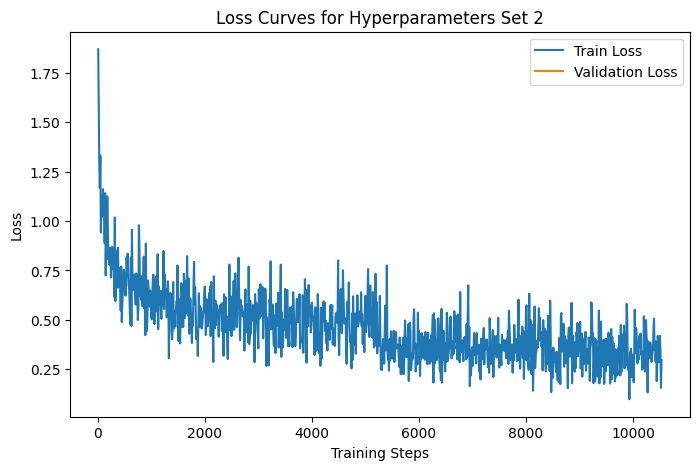


✅ Best hyperparameters: {'weight_decay': 0.0, 'train_batch_size': 8, 'num_train_epochs': 2, 'learning_rate': 5e-05, 'eval_batch_size': 8}
✅ Best validation accuracy: 0.8311


In [ ]:
# Define hyperparameter space
param_space = {
    'learning_rate': [2e-5, 3e-5, 5e-5],
    'train_batch_size': [8, 16],
    'eval_batch_size': [8],
    'num_train_epochs': [2, 3],
    'weight_decay': [0.0, 0.01]
}

# Randomly sample 5 hyperparameter sets
random.seed(42)
sampled_params = list(ParameterSampler(param_space, n_iter=2, random_state=42))
print(f"Total sampled hyperparameter sets: {len(sampled_params)}")

best_acc = 0
best_trainer = None
best_params = None

for i, params in enumerate(sampled_params):
    print(f"\n🔹 Running hyperparameter set {i+1}/{len(sampled_params)}: {params}")
    trainer, results, train_loss, eval_loss = train_and_evaluate(params)

    # Plot losses
    plt.figure(figsize=(8,5))
    plt.plot(train_loss['step'], train_loss['loss'], label='Train Loss')
    plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Validation Loss')
    plt.title(f"Loss Curves for Hyperparameters Set {i+1}")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Update best model
    if results['eval_accuracy'] > best_acc:
        best_acc = results['eval_accuracy']
        best_trainer = trainer
        best_params = params

print(f"\n✅ Best hyperparameters: {best_params}")
print(f"✅ Best validation accuracy: {best_acc:.4f}")

In [ ]:
import torch

print("\n🧩 Test the trained model with your own statements!")

user_statements = []
while True:
    text = input("\nEnter a mental health-related statement (or type 'stop' to finish): ")
    if text.lower() == "stop":
        break
    user_statements.append(text)

if user_statements:
    # Tokenize user input
    test_encodings = tokenizer(
        user_statements,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors="pt"
    )

    # Move encodings to the same device as the model
    device = next(best_trainer.model.parameters()).device
    test_encodings = {k: v.to(device) for k, v in test_encodings.items()}

    # Run inference
    best_trainer.model.eval()
    with torch.no_grad():
        outputs = best_trainer.model(**test_encodings)
        preds = torch.argmax(outputs.logits, dim=1).tolist()

    # Convert labels back to text
    inv_label_map = {v: k for k, v in label_map.items()}

    print("\n🧠 Model Predictions:")
    for i, text in enumerate(user_statements):
        print(f"  ➤ '{text}' → Predicted: {inv_label_map[preds[i]]}")



🧩 Test the trained model with your own statements!

Enter a mental health-related statement (or type 'stop' to finish): i feel nervous all the time

Enter a mental health-related statement (or type 'stop' to finish): i feel alone

Enter a mental health-related statement (or type 'stop' to finish): stop

🧠 Model Predictions:
  ➤ 'i feel nervous all the time' → Predicted: Anxiety
  ➤ 'i feel alone' → Predicted: Depression
